# Self-Supervision with FastAI
> A tutorial of rotation-based self-supervision using FastAI2 & PyTorch!

# Introduction

This notebook is an introduction to self-supervised learning. In short, self-supervised learning has 2 components:

1. Pretrain on a pretext task, where the labels can come from the data itself!
2. Transfer the features, and train on the actual classification labels!

Using FastAI2, we'll use rotation as a pretext task for learning representations/features of our data. 

Here are some great overviews of self-supervised learning that I've come across:

- [Lilian Weng - Self-Supervised Representation Learning](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning)

- [Jeremy Howard - Self-supervised learning and computer vision](https://www.fast.ai/2020/01/13/self_supervised/)

# Experiment Layout

In this notebook, we will be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

Also check out [ImageWang](https://github.com/fastai/imagenette#image%E7%BD%91) from FastAI themselves! It's a dataset designed for self-supervision tasks!

1. Train a model on a rotation prediction task.
  - We will use *all* the training data for rotation prediction.
  - Input: A rotated image.
  - Target/Label: Classify the amount of degrees rotated.
  - Our model should learn useful features that can transfer well for a classification task.
  - (The model should learn what digits look like in order to be able to successfully predict the amount of rotation).

2. Transfer our rotation pretraining features to solve the classification task with *much fewer* labels, < 1% of the original data.
  - Input: A normal image.
  - Target/Label: The images' *original* categorical label.
  - Classification accuracy should be decent, even with only using < 1% of the original data.

3. Train a classifier from scratch on the same amount of data used in experiment 2.
  - Input: A normal image.
  - Target/Label: The images' *original* categorical label.
  - Classification accuracy should be low (lack of transfer learning & too few labeled data!)
  - Model may overfit.  

# FastAI Vision Model Creation Methods

> Warning: This Jupyter notebook runs with fastai2! Make sure you have it installed, use the cell below to install it :)

pretext task 

In [1]:
!pip install fastai --upgrade

# Uncomment and run the below line to get a fresh install of fastai, if needed
# !pip install fastai --upgrade

     ------------------------------------- 197.9/197.9 kB 12.5 MB/s eta 0:00:00
     ---------------------------------------- 60.0/60.0 kB 3.1 MB/s eta 0:00:00
     --------------------------------------- 11.9/11.9 MB 40.9 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp37-cp37m-win_amd64.whl (153 kB)
     ---------------------------------------- 42.8/42.8 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 133.1/133.1 kB ? eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 29.9 MB/s eta 0:00:00
     ---------------------------------------- 447.2/447.2 kB ? eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 33.4 MB/s eta 0:00:00
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
     ---------------------------------------- 181.6/181.6 kB ? eta 0:00:00
     ---------------------------------------- 108.7/108.7 kB ? eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 30.3 MB/s eta 0:00:00
     ----------------------

> Important: Pay attention! It's important. We will be using a small ConvNet to test our self-supervised learning method. The architecture is defined below in `simple_arch`.

Note that `simple_arch` takes in one argument, `pretrained`. This is to allow FastAI to pass `pretrained=True` or `pretrained=False` when creating the model body! Below are some use cases of when we would want `pretrained=True` or `pretrained=False`.

1. `pretrained=False` = For training a new model on our rotation prediction task.
2. `pretrained=True` = For transferring the learnt features from our rotation task pretraining to solve a classification task.
3. `pretrained=False` = For training a new model from scratch on the main classification task (no transfer learning).

In [2]:
from fastai.vision.all import *

c:\Users\SNU AI\anaconda3\envs\SKLAB\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#collapse-show
def simple_arch(pretrained=False):
    # Note that FastAI will automatically cut at pooling layer for the body!
    model = nn.Sequential(
        nn.Conv2d(1, 4, 3, 1),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.Conv2d(4, 16, 3, 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, 1),
        nn.BatchNorm2d(32),
        nn.AdaptiveAvgPool2d(1),
    )
    if (pretrained):
        print("Loading pretrained model...")
        pretrained_weights = torch.load(save_path/'rot_pretrained.pt')
        print(model.load_state_dict(pretrained_weights))
    return model

> The follow below code snippets are examples of how FastAI creates CNNs. Every model will have a *body* and a *head*

In [4]:
#collapse-show
body = create_body(arch=simple_arch, pretrained=False)
body

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
#collapse-show
head = create_head(nf=32, n_out=8, lin_ftrs=[])
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=64, out_features=8, bias=False)
)

In [5]:
#collapse-show
# Note that FastAI automatically determines nf for the head!
model = create_cnn_model(arch=simple_arch, pretrained=False, n_out=8, lin_ftrs=[])
model

c:\Users\SNU AI\anaconda3\envs\SKLAB\lib\site-packages\fastai\vision\learner.py:259: UserWarning: `create_cnn_model` has been renamed to `create_vision_model` -- please update your code
  warn("`create_cnn_model` has been renamed to `create_vision_model` -- please update your code")


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=8, bias=False)
  )
)

# PyTorch Rotation/Classification Self-Supervised Dataset

In [6]:
# --- Functions to convert between Torch Tensors and PIL Images ---
import torchvision
tensorToImage = torchvision.transforms.ToPILImage()
imageToTensor = torchvision.transforms.ToTensor()

In [ ]:
#collapse-hide
# Uncomment and run the below lines if torchvision has trouble downloading MNIST (in the next cell)

# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [7]:
# Download MNIST dataset from PyTorch if not downloaded already!
torchvision.datasets.MNIST('data', download=True)

9913344it [00:00, 37911351.81it/s]                             


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



29696it [00:00, 4335330.72it/s]          


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



1649664it [00:00, 9859418.93it/s]                            


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



5120it [00:00, 4928812.60it/s]          

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

Below we define a dataset, here's the docstring:

A Dataset for Rotation-based Self-Supervision! Images are rotated clockwise.
- `file` - MNIST processed .pt file.
- `pct` - percent of data to use
- `classification` - False=Use rotation labels. True=Use original classification labels.

In [9]:
from torchvision.datasets.mnist import read_image_file, read_label_file

#collapse-hide
class Custom_Dataset_MNIST():
    '''
    A Dataset for Rotation-based Self-Supervision! Images are rotated clockwise.
    - file - MNIST processed .pt file.
    - pct - percent of data to use
    - classification - False=Use rotation labels. True=Use original classification labels.
    '''
    
    def __init__(self, file, pct, classification):
        
        #data = torch.load(file)
        self.imgs = read_image_file(file) #data[0]
        self.labels = read_label_file(file.replace('images-idx3', 'labels-idx1')) #data[1]
        self.pct = pct
        self.classification = classification
                    
        slice_idx = int(len(self.imgs)*self.pct)
        self.imgs = self.imgs[:slice_idx]
                    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx].unsqueeze(0)
        img = tensorToImage(img)
        img = img.resize((32, 32), resample=1)
        img = imageToTensor(img)
        
        if (not self.classification):
            # 4 classes for rotation
            degrees = [0, 45, 90, 135, 180, 225, 270, 315]
            rand_choice = random.randint(0, len(degrees)-1)
            
            img = tensorToImage(img)
            img = img.rotate(degrees[rand_choice])
            img = imageToTensor(img)
            return img, torch.tensor(rand_choice).long()
        
        return img, self.labels[idx]
    
    def show_batch(self, n=3):
        fig, axs = plt.subplots(n, n)
        fig.tight_layout()
        for i in range(n):
            for j in range(n):
                rand_idx = random.randint(0, len(self)-1)
                img, label = self.__getitem__(rand_idx)
                axs[i, j].imshow(tensorToImage(img), cmap='gray')
                if self.classification:
                    axs[i, j].set_title('Label: {0} (Digit #{1})'.format(label.item(), label.item()))
                else:
                    axs[i, j].set_title('Label: {0} ({1} Degrees)'.format(label.item(), label.item()*45))
                axs[i, j].axis('off')

# Rotation Prediction Data

> Important: 60k training data and 10k validation data!

In [10]:
# Make rotation datasets
train_ds = Custom_Dataset_MNIST('data/MNIST/raw/train-images-idx3-ubyte', pct=1.0, classification=False)
valid_ds = Custom_Dataset_MNIST('data/MNIST/raw/t10k-images-idx3-ubyte', pct=1.0, classification=False)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

60000 Training Samples | 10000 Validation Samples


> Note: Notice that our labels don't correspond to digits! They correspond to the amount of degrees rotated! Specifically from this predefined set: `[0, 45, 90, 135, 180, 225, 270, 315]`

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


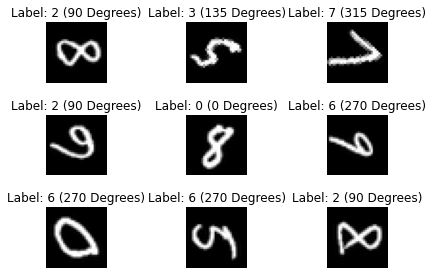

In [11]:
from fastai.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()

# Override the show_batch function of dls to the one used in our dataset!
dls.show_batch = train_ds.show_batch

# We have 8 classes! [0, 1, 2, 3, 4, 5, 6, 7] that correspond to the [0, 45, 90, 135, 180, 225, 270, 315] degrees of rotation.
dls.c = 8

dls.show_batch()

# FastAI Vision Learner [Rotation]

In [12]:
# Create a config for our model's head!
rotation_head = create_head(nf=32, n_out=8, lin_ftrs=[])
rotation_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=64, out_features=8, bias=False)
)

> Note: We want to measure `top_2_accuracy` along with regular (top_1) accuracy, because there are hard-cases where it's understandable why our model got it wrong. For example: '0' rotated 90 or 270 degrees, or '1' rotated 0 or 180 degrees. (They can look the same!)

In [13]:
# Top_2 accuracy is a nice metric for hard-cases:
# - A zero rotated 90 or 270 degrees?
# - A one rotated 0 or 180 degrees?
# etc :P

top_2_accuracy = lambda inp, targ: top_k_accuracy(inp, targ, k=2)
top_2_accuracy

<function __main__.<lambda>(inp, targ)>

Here, we train a model on the rotation prediction task!

In [14]:
#collapse-show
# Note to set a value for lin_ftrs, we use the defined config above.
learner = cnn_learner(dls,
                      simple_arch, #body 
                      pretrained=False,
                      loss_func=CrossEntropyLossFlat(),
                      custom_head=rotation_head,
                      metrics=[accuracy, top_2_accuracy])

learner.model

c:\Users\SNU AI\anaconda3\envs\SKLAB\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=8, bias=False)
  )
)

In [15]:
learner.summary()

Sequential (Input shape: 64 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 30 x 30    
Conv2d                                    40         True      
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 28 x 28   
Conv2d                                    592        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 26 x 26   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
____________________________________________________________________________
                     64 

SuggestedLRs(valley=0.00363078061491251)

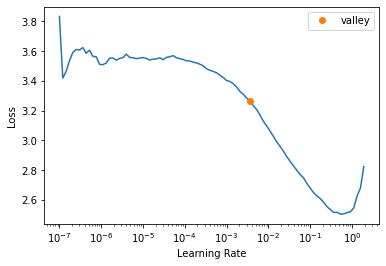

In [16]:
learner.lr_find()

In [17]:
# Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates
learner.fit_one_cycle(5, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,,time
0,0.940137,1.240219,0.476400,0.774500,01:06
1,0.833849,0.989961,0.586200,0.836700,01:06
2,0.744436,1.540369,0.447300,0.811900,01:04
3,0.632251,0.551554,0.762400,0.966100,01:05
4,0.584828,0.500617,0.791200,0.972100,01:07


> Important: We were able to achieve 76.2% top-1 accuracy, and 96.8% top-2 accuracy after just 5 epochs! Now we want to grab our `model` from our `Learner`, and save the body of it!

> Note: Our `model` has two components, the *body* and the *head*. `model` is a list of size 2, where `model[0]` is the body, and `model[1]` is the head!

In [18]:
# Access the body of our model
trained_body = learner.model[0]
trained_body

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

> Tip: To save a model in PyTorch, save it's `state_dict` function! You can use `model.load_state_dict` to re-load the weights.

In [19]:
# Make save directory if it doesn't exist
save_path = Path('rotation_cps/')
if not save_path.exists():
    save_path.mkdir()

# Save the rotation-pretraining weights of our model body
torch.save(trained_body.state_dict(), save_path/'rot_pretrained.pt')

# Original Classification Data

Now that we have pretrained our model on the rotation prediction task, we want to switch over to the original labeled data for the classification task.

> Important: We're only using 180 samples for training!

In [20]:
# Use 0.3% classification labeled data for training!
# Use 100% classification labeled data for validation!
train_ds = Custom_Dataset_MNIST('data/MNIST/raw/train-images-idx3-ubyte', pct=0.003, classification=True)
valid_ds = Custom_Dataset_MNIST('data/MNIST/raw/t10k-images-idx3-ubyte', pct=1.0, classification=True)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

180 Training Samples | 10000 Validation Samples


> Note: Notice the labels now correspond to the digit class!

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


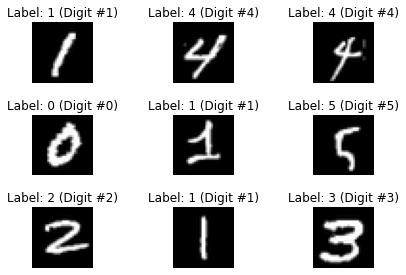

In [21]:
from fastai.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()
dls.show_batch = train_ds.show_batch

# We have 10 classes! One for each digit label!
dls.c = 10

dls.show_batch()

# FastAI Vision Learner [Transfer-Classification]

Here we will toggle `pretrained=True` to transfer our rotation prediction features, and train on the original 180 labeled data.

In [22]:
#collapse-show
classification_head = create_head(nf=32, n_out=10, lin_ftrs=[])
classification_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=64, out_features=10, bias=False)
)

> Note: We have `n_out=10` because of the 10 different digit classes

In [23]:
#collapse-show
# pretrained=True will load the saved rotation pretraining weights into our model's body!
# See simple_arch() function definition for more details!
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=True, #Different!
                      loss_func=CrossEntropyLossFlat(),
                      custom_head=classification_head, #Different!
                      metrics=[accuracy])

learner.model

Loading pretrained model...
<All keys matched successfully>


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=False)
  )
)

> Tip: Freezing a model's body after transferring the weights over, allows the new head to get *calibrated* with the rest of the model!

In [24]:
learner.freeze() #이미 training 된 부분은 freeze 

> Note: Looking at the model summary, we can see that the model is frozen up to the new head! Good!

In [25]:
learner.summary()

Sequential (Input shape: 64 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 30 x 30    
Conv2d                                    40         False     
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 28 x 28   
Conv2d                                    592        False     
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 26 x 26   
Conv2d                                    4640       False     
BatchNorm2d                               64         True      
____________________________________________________________________________
                     64 

SuggestedLRs(valley=0.007585775572806597)

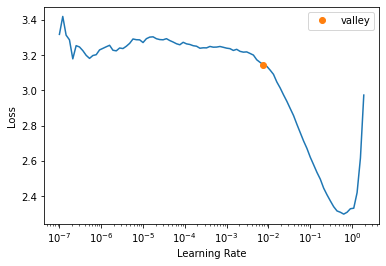

In [26]:
learner.lr_find()

In [27]:
learner.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.326165,3.194579,0.124500,00:03
1,3.206526,2.935570,0.142100,00:03
2,2.943216,2.644202,0.173100,00:04
3,2.625532,2.469642,0.161200,00:03
4,2.393460,2.252480,0.179000,00:04
5,2.155726,2.167502,0.205100,00:03
6,1.989486,2.052969,0.250700,00:04
7,1.897309,1.862367,0.341300,00:04
8,1.778619,1.721617,0.415700,00:03
9,1.686296,1.611996,0.475500,00:03


> Tip: Unfreeze the model after calibrating the new head with the transferred body, and train a little more!

In [28]:
learner.unfreeze()

In [29]:
learner.summary()

Sequential (Input shape: 64 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 30 x 30    
Conv2d                                    40         True      
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 28 x 28   
Conv2d                                    592        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 26 x 26   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
____________________________________________________________________________
                     64 

SuggestedLRs(valley=0.004365158267319202)

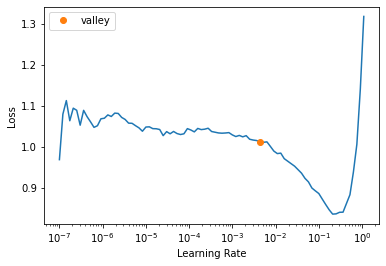

In [30]:
learner.lr_find()

In [31]:
learner.fine_tune(5, base_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.919109,1.490556,0.538900,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.920061,1.422972,0.570800,00:03
1,0.885685,1.363240,0.588900,00:03
2,0.857720,1.297711,0.602200,00:03
3,0.851611,1.245313,0.612500,00:04
4,0.873440,1.205589,0.626800,00:03


> Important: We were able to get decent accuracy using transfer learning from our pretraining on the rotation prediction task!

# FastAI Vision Learner [From Scratch-Classification]



Here we train a model from scratch on the original 180 labeled data.

In [32]:
#collapse-show
# pretrained=False, Create the same model as before, but without using the rotation pretraining weights!
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=False,
                      loss_func=CrossEntropyLossFlat(),
                      custom_head=classification_head,
                      metrics=[accuracy])

learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=False)
  )
)

In [33]:
learner.summary()

Sequential (Input shape: 64 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 30 x 30    
Conv2d                                    40         True      
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 28 x 28   
Conv2d                                    592        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 26 x 26   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
____________________________________________________________________________
                     64 

SuggestedLRs(valley=0.00363078061491251)

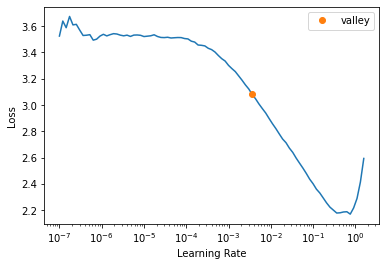

In [34]:
learner.lr_find()

In [35]:
learner.fit_one_cycle(20, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.536847,6.204277,0.089200,00:04
1,3.111600,5.901546,0.089200,00:04
2,2.665699,6.051003,0.101000,00:03
3,2.376322,6.489028,0.103400,00:04
4,2.158573,7.432230,0.128100,00:04
5,2.003781,7.932487,0.165700,00:03
6,1.881361,7.804899,0.136200,00:03
7,1.750113,7.574862,0.126700,00:03
8,1.650837,8.093828,0.116900,00:03
9,1.566202,8.386190,0.114800,00:04


> Important: We were able to only get subpar accuracy with training from scratch